In [6]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import time 
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
import plotly.graph_objects as go
import re 
import nltk  
nltk.download('stopwords') 
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer 
from collections import Counter
import cufflinks as cf
cf.go_offline()

[nltk_data] Downloading package stopwords to /home/user4/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [10]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [12]:
missing = train.isnull().sum()  


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [13]:
missing[missing>0].sort_values(ascending=False).iplot(kind='bar',title='Null values present in train Dataset', color=['red'])

In [14]:
train.target.value_counts().iplot(kind='bar',text=['Fake', 'Real'], title='Comparing Tweet is a real disaster (1) or not (0)',color=['blue'])

In [15]:
train.keyword.nunique()

221

In [17]:
train.keyword.value_counts()[:20].iplot(kind='bar', title='Top 20 keywords in text', color='red')

In [18]:
train.location.value_counts()[:20].iplot(kind='bar', title='Top 20 location in tweet', color='blue')

In [22]:
STOPWORDS.add('https')
def Plot_world(text):
    
    comment_words = ' '
    stopwords = set(STOPWORDS) 
    
    for val in text: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        for words in tokens: 
            comment_words = comment_words + words + ' '


    wordcloud = WordCloud(width = 5000, height = 4000, 
                    background_color ='black', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image  
    plt.figure(figsize = (12, 12), facecolor = 'k', edgecolor = 'k' ) 
    plt.imshow(wordcloud) 
    plt.axis("off")
    plt.tight_layout(pad = 0) 
    plt.show() 

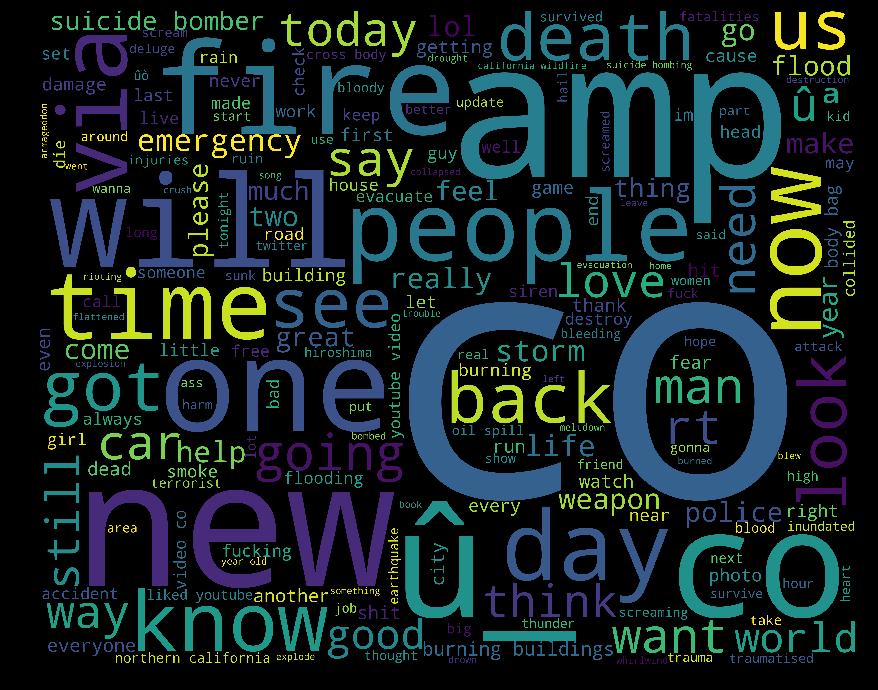

In [23]:
text = train.text.values

Plot_world(text)

In [24]:
train.loc[train['text'].str.contains('http')].target.value_counts()

1    2172
0    1799
Name: target, dtype: int64

In [25]:
pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
def remove_html(text):
    no_html= pattern.sub('',text)
    return no_html

In [29]:
train['text']=train['text'].apply(lambda x : remove_html(x))

In [30]:
train.loc[train['text'].str.contains('http')].target.value_counts()

0    1
Name: target, dtype: int64

In [31]:
test['text']=test['text'].apply(lambda x : remove_html(x))

In [32]:
def clean_text(text):
 
    text = re.sub('[^a-zA-Z]', ' ', text)  

    text = text.lower()  

    # split to array(default delimiter is " ") 
    text = text.split()  
    
    text = [w for w in text if not w in set(stopwords.words('english'))] 

    text = ' '.join(text)    
            
    return text

In [33]:
train['text'] = train['text'].apply(lambda x : clean_text(x))

In [34]:
test['text']=test['text'].apply(lambda x : clean_text(x))

In [35]:
def counter_word (text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [36]:
text_values = train["text"]

counter = counter_word(text_values)

In [37]:
print(f"The len of unique words is: {len(counter)}")
list(counter.items())[:10]

The len of unique words is: 16070


[('deeds', 2),
 ('reason', 20),
 ('earthquake', 50),
 ('may', 89),
 ('allah', 9),
 ('forgive', 2),
 ('us', 128),
 ('forest', 66),
 ('fire', 254),
 ('near', 56)]

In [38]:

vocab_size = len(counter)
embedding_dim = 32

# Max number of words in each complaint.
max_length = 20
trunc_type='post'
padding_type='post'

# oov_took its set for words out our word index
oov_tok = "<XXX>"
training_size = 6090
seq_len = 12

In [39]:
training_sentences = train.text[0:training_size]
training_labels = train.target[0:training_size]

testing_sentences = train.text[training_size:]
testing_labels = train.target[training_size:]

In [40]:
print('The Shape of training ',training_sentences.shape)
print('The Shape of testing',testing_sentences.shape)

The Shape of training  (6090,)
The Shape of testing (1523,)


In [41]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

In [42]:
word_index = tokenizer.word_index

In [43]:
print("THe first word Index are: ")
for x in list(word_index)[0:15]:
    print (" {},  {} ".format(x,  word_index[x]))

THe first word Index are: 
 <XXX>,  1 
 amp,  2 
 like,  3 
 fire,  4 
 get,  5 
 via,  6 
 new,  7 
 people,  8 
 news,  9 
 emergency,  10 
 one,  11 
 disaster,  12 
 body,  13 
 video,  14 
 burning,  15 


In [44]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [45]:
print(train.text[1])
print(training_sequences[1])

forest fire near la ronge sask canada
[74, 4, 120, 571, 5480, 5481, 1184]


In [46]:
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [48]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(14, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # remember this is a binary clasification
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [54]:
start_time = time.time()
num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))

final_time = (time.time()- start_time)/60
print(f'The time in minutos: {final_time}')

Train on 6090 samples, validate on 1523 samples
Epoch 1/10
6090/6090 [==============================] - 2s 358us/sample - loss: 0.0324 - accuracy: 0.9828 - val_loss: 1.5052 - val_accuracy: 0.6848
Epoch 2/10
6090/6090 [==============================] - 2s 335us/sample - loss: 0.0331 - accuracy: 0.9836 - val_loss: 1.5353 - val_accuracy: 0.6763
Epoch 3/10
6090/6090 [==============================] - 2s 328us/sample - loss: 0.0304 - accuracy: 0.9836 - val_loss: 1.5797 - val_accuracy: 0.6763
Epoch 4/10
6090/6090 [==============================] - 2s 343us/sample - loss: 0.0314 - accuracy: 0.9836 - val_loss: 1.8815 - val_accuracy: 0.6638
Epoch 5/10
6090/6090 [==============================] - 2s 356us/sample - loss: 0.0320 - accuracy: 0.9837 - val_loss: 2.0375 - val_accuracy: 0.6474
Epoch 6/10
6090/6090 [==============================] - 2s 359us/sample - loss: 0.0335 - accuracy: 0.9837 - val_loss: 1.7765 - val_accuracy: 0.6783
Epoch 7/10
6090/6090 [==============================] - 2s 343us

In [55]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

,loss,accuracy,val_loss,val_accuracy
0,0.032359,0.982759,1.505190,0.684833
1,0.033125,0.983580,1.535319,0.676297
2,0.030436,0.983580,1.579692,0.676297
3,0.031362,0.983580,1.881457,0.663821
4,0.031990,0.983744,2.037519,0.647406


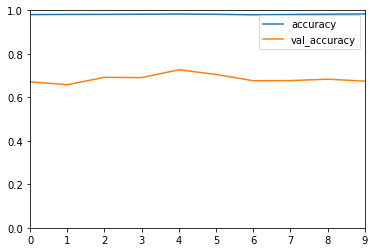

In [53]:
model_loss[['accuracy','val_accuracy']].plot(ylim=[0,1]);